# Student Dataset - Workday Alohol Consumption

This notebooks looks at how aif360 handles the student performance dataset with Workday Alcohol Consumption as protected attribute

In [5]:
# Python vanilla libs
import os
import datetime
import logging
import importlib

# Aif360 content
# from aif360.sklearn.preprocessing import LearnedFairRepresentations
# from aif360.sklearn.inprocessing import AdversarialDebiasing
# from modules.aif360.aif360_instance import Aif360Instance
from aif360.sklearn.postprocessing import RejectOptionClassifierCV, PostProcessingMeta
from aif360.sklearn.metrics import consistency_score
from aif360.sklearn.detectors import bias_scan
from aif360.datasets.structured_dataset import StructuredDataset
from aif360.datasets.binary_label_dataset import BinaryLabelDataset
from aif360.datasets.standard_dataset import StandardDataset
# from aif360.examples.common_utils import compute_metrics


# Other usefull third party libraries
import sklearn
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier

import pandas as pd
import matplotlib.pyplot as plt

from IPython.display import Markdown, display, HTML

# Finally, the own modules
from modules.gen_purp.get_repo import get_uci_repo
from modules.gen_purp.data_preprocessing import preprocessing as aif360prep
from modules.display import data_display
from modules.ml import ml_methods
from modules.aifairn360.dataset import inst_dataset
from modules.metrics import calc_metrics
from modules.aifairn360 import preprocessing, inprocessing, postprocessing

# And the config
now = datetime.datetime.now()

cfg = {
    'main_path': os.getcwd(),
    'now': now,
    'read': {
        'sep': ','
    },
    # All params concerning the student performance dataset
    'student_ds': {
        'data_id': 320,
        'data_name': 'student_performance',
        'prot_attr': ['sex', 'Dalc'],
        'priv_cls': ['M', lambda x: x >= 3]
    },
    # All params for displaying data
    'display': {
        'out_file': os.path.join(os.getcwd(), 'out', f'display_{now.day}-{now.month}-{now.year}.txt'),
        'inst': ('head', 'summary', 'describe', 'skew', 'standard_error')
    }
}

In [6]:
# Get the data
data = get_uci_repo(main_path=cfg['main_path'], data_id=cfg['student_ds']['data_id'], data_name=cfg['student_ds']['data_name'])
feat, targets = data[0], data[1]

In [7]:
# Display the features
display(HTML(feat.head(10).to_html()))

,Unnamed: 0,school,sex,age,address,famsize,Pstatus,Medu,Fedu,Mjob,Fjob,reason,guardian,traveltime,studytime,failures,schoolsup,famsup,paid,activities,nursery,higher,internet,romantic,famrel,freetime,goout,Dalc,Walc,health,absences
0,0,GP,F,18,U,GT3,A,4,4,at_home,teacher,course,mother,2,2,0,yes,no,no,no,yes,yes,no,no,4,3,4,1,1,3,4
1,1,GP,F,17,U,GT3,T,1,1,at_home,other,course,father,1,2,0,no,yes,no,no,no,yes,yes,no,5,3,3,1,1,3,2
2,2,GP,F,15,U,LE3,T,1,1,at_home,other,other,mother,1,2,0,yes,no,no,no,yes,yes,yes,no,4,3,2,2,3,3,6
3,3,GP,F,15,U,GT3,T,4,2,health,services,home,mother,1,3,0,no,yes,no,yes,yes,yes,yes,yes,3,2,2,1,1,5,0
4,4,GP,F,16,U,GT3,T,3,3,other,other,home,father,1,2,0,no,yes,no,no,yes,yes,no,no,4,3,2,1,2,5,0
5,5,GP,M,16,U,LE3,T,4,3,services,other,reputation,mother,1,2,0,no,yes,no,yes,yes,yes,yes,no,5,4,2,1,2,5,6
6,6,GP,M,16,U,LE3,T,2,2,other,other,home,mother,1,2,0,no,no,no,no,yes,yes,yes,no,4,4,4,1,1,3,0
7,7,GP,F,17,U,GT3,A,4,4,other,teacher,home,mother,2,2,0,yes,yes,no,no,yes,yes,no,no,4,1,4,1,1,1,2
8,8,GP,M,15,U,LE3,A,3,2,services,other,home,mother,1,2,0,no,yes,no,no,yes,yes,yes,no,4,2,2,1,1,1,0
9,9,GP,M,15,U,GT3,T,3,4,other,other,home,mother,1,2,0,no,yes,no,yes,yes,yes,yes,no,5,5,1,1,1,5,0


In [8]:
# Display the targets
display(HTML(feat.head(10).to_html()))
# Check all possible target classifications
targets['G3'].unique()

,Unnamed: 0,school,sex,age,address,famsize,Pstatus,Medu,Fedu,Mjob,Fjob,reason,guardian,traveltime,studytime,failures,schoolsup,famsup,paid,activities,nursery,higher,internet,romantic,famrel,freetime,goout,Dalc,Walc,health,absences
0,0,GP,F,18,U,GT3,A,4,4,at_home,teacher,course,mother,2,2,0,yes,no,no,no,yes,yes,no,no,4,3,4,1,1,3,4
1,1,GP,F,17,U,GT3,T,1,1,at_home,other,course,father,1,2,0,no,yes,no,no,no,yes,yes,no,5,3,3,1,1,3,2
2,2,GP,F,15,U,LE3,T,1,1,at_home,other,other,mother,1,2,0,yes,no,no,no,yes,yes,yes,no,4,3,2,2,3,3,6
3,3,GP,F,15,U,GT3,T,4,2,health,services,home,mother,1,3,0,no,yes,no,yes,yes,yes,yes,yes,3,2,2,1,1,5,0
4,4,GP,F,16,U,GT3,T,3,3,other,other,home,father,1,2,0,no,yes,no,no,yes,yes,no,no,4,3,2,1,2,5,0
5,5,GP,M,16,U,LE3,T,4,3,services,other,reputation,mother,1,2,0,no,yes,no,yes,yes,yes,yes,no,5,4,2,1,2,5,6
6,6,GP,M,16,U,LE3,T,2,2,other,other,home,mother,1,2,0,no,no,no,no,yes,yes,yes,no,4,4,4,1,1,3,0
7,7,GP,F,17,U,GT3,A,4,4,other,teacher,home,mother,2,2,0,yes,yes,no,no,yes,yes,no,no,4,1,4,1,1,1,2
8,8,GP,M,15,U,LE3,A,3,2,services,other,home,mother,1,2,0,no,yes,no,no,yes,yes,yes,no,4,2,2,1,1,1,0
9,9,GP,M,15,U,GT3,T,3,4,other,other,home,mother,1,2,0,no,yes,no,yes,yes,yes,yes,no,5,5,1,1,1,5,0


array([11, 12, 14, 13, 17, 15,  7, 10, 16,  9,  8, 18,  6,  0,  1,  5, 19],
      dtype=int64)

## Data Cleaning

Seeing the data initially, the following points are to consider
- Fill the NaNs where possible
- Conver "yes" and "no" to True and False
- Transfer to dummy values
- Extract the last semester as target
- Drop old index columns ("unnamed: 0")

In [9]:
# To fill the nulls, we first need to see which columns apply for an average
print(feat.columns)
print(feat.dtypes)

Index(['Unnamed: 0', 'school', 'sex', 'age', 'address', 'famsize', 'Pstatus',
       'Medu', 'Fedu', 'Mjob', 'Fjob', 'reason', 'guardian', 'traveltime',
       'studytime', 'failures', 'schoolsup', 'famsup', 'paid', 'activities',
       'nursery', 'higher', 'internet', 'romantic', 'famrel', 'freetime',
       'goout', 'Dalc', 'Walc', 'health', 'absences'],
      dtype='object')
Unnamed: 0     int64
school        object
sex           object
age            int64
address       object
famsize       object
Pstatus       object
Medu           int64
Fedu           int64
Mjob          object
Fjob          object
reason        object
guardian      object
traveltime     int64
studytime      int64
failures       int64
schoolsup     object
famsup        object
paid          object
activities    object
nursery       object
higher        object
internet      object
romantic      object
famrel         int64
freetime       int64
goout          int64
Dalc           int64
Walc           int64
health    

The dataset consists of categorical data exclusively. So we use the median to fill the nulls (and round them in case the result is a decimal number)

In [10]:
# First extract the column to protect
protect_col = feat['Dalc']
# Then drop all unwanted cols
dropped = feat.drop(columns=['Unnamed: 0', 'Dalc'])
# Convert the booleans
dropped = dropped.map(lambda x: 1 if isinstance(x, object) and x == 'yes' else 0 if isinstance(x, object) and x == 'no' else x)
# Then convert the remaining cols to dummies
dummies = pd.get_dummies(dropped)
# Finally, fill the Nulls with the (rounded) median
cleaned = dummies.fillna(feat.median(numeric_only=True).round())
cleaned = cleaned.assign(Dalc=protect_col)

Check the data again

In [11]:
display(HTML(cleaned.head(10).to_html()))

,age,Medu,Fedu,traveltime,studytime,failures,schoolsup,famsup,paid,activities,nursery,higher,internet,romantic,famrel,freetime,goout,Walc,health,absences,school_GP,school_MS,sex_F,sex_M,address_R,address_U,famsize_GT3,famsize_LE3,Pstatus_A,Pstatus_T,Mjob_at_home,Mjob_health,Mjob_other,Mjob_services,Mjob_teacher,Fjob_at_home,Fjob_health,Fjob_other,Fjob_services,Fjob_teacher,reason_course,reason_home,reason_other,reason_reputation,guardian_father,guardian_mother,guardian_other,Dalc
0,18,4,4,2,2,0,1,0,0,0,1,1,0,0,4,3,4,1,3,4,True,False,True,False,False,True,True,False,True,False,True,False,False,False,False,False,False,False,False,True,True,False,False,False,False,True,False,1
1,17,1,1,1,2,0,0,1,0,0,0,1,1,0,5,3,3,1,3,2,True,False,True,False,False,True,True,False,False,True,True,False,False,False,False,False,False,True,False,False,True,False,False,False,True,False,False,1
2,15,1,1,1,2,0,1,0,0,0,1,1,1,0,4,3,2,3,3,6,True,False,True,False,False,True,False,True,False,True,True,False,False,False,False,False,False,True,False,False,False,False,True,False,False,True,False,2
3,15,4,2,1,3,0,0,1,0,1,1,1,1,1,3,2,2,1,5,0,True,False,True,False,False,True,True,False,False,True,False,True,False,False,False,False,False,False,True,False,False,True,False,False,False,True,False,1
4,16,3,3,1,2,0,0,1,0,0,1,1,0,0,4,3,2,2,5,0,True,False,True,False,False,True,True,False,False,True,False,False,True,False,False,False,False,True,False,False,False,True,False,False,True,False,False,1
5,16,4,3,1,2,0,0,1,0,1,1,1,1,0,5,4,2,2,5,6,True,False,False,True,False,True,False,True,False,True,False,False,False,True,False,False,False,True,False,False,False,False,False,True,False,True,False,1
6,16,2,2,1,2,0,0,0,0,0,1,1,1,0,4,4,4,1,3,0,True,False,False,True,False,True,False,True,False,True,False,False,True,False,False,False,False,True,False,False,False,True,False,False,False,True,False,1
7,17,4,4,2,2,0,1,1,0,0,1,1,0,0,4,1,4,1,1,2,True,False,True,False,False,True,True,False,True,False,False,False,True,False,False,False,False,False,False,True,False,True,False,False,False,True,False,1
8,15,3,2,1,2,0,0,1,0,0,1,1,1,0,4,2,2,1,1,0,True,False,False,True,False,True,False,True,True,False,False,False,False,True,False,False,False,True,False,False,False,True,False,False,False,True,False,1
9,15,3,4,1,2,0,0,1,0,1,1,1,1,0,5,5,1,1,5,0,True,False,False,True,False,True,True,False,False,True,False,False,True,False,False,False,False,True,False,False,False,True,False,False,False,True,False,1


In [12]:
# Check if the null conversion has worked
print(cleaned.isnull().values.any())

False


In [13]:
# Finally, get the target vals
targ = targets['G3']

## Creating a dataset for aif360

aif360 uses a custom datastructure they call datasets. Thus, one needs to be created. To do so, a protected attribute, and what is considered priviledged and unpriviledges, as well as a distinction between these two has to be defined first.

In [14]:
# Get all the new columns
print(cleaned.columns)

Index(['age', 'Medu', 'Fedu', 'traveltime', 'studytime', 'failures',
       'schoolsup', 'famsup', 'paid', 'activities', 'nursery', 'higher',
       'internet', 'romantic', 'famrel', 'freetime', 'goout', 'Walc', 'health',
       'absences', 'school_GP', 'school_MS', 'sex_F', 'sex_M', 'address_R',
       'address_U', 'famsize_GT3', 'famsize_LE3', 'Pstatus_A', 'Pstatus_T',
       'Mjob_at_home', 'Mjob_health', 'Mjob_other', 'Mjob_services',
       'Mjob_teacher', 'Fjob_at_home', 'Fjob_health', 'Fjob_other',
       'Fjob_services', 'Fjob_teacher', 'reason_course', 'reason_home',
       'reason_other', 'reason_reputation', 'guardian_father',
       'guardian_mother', 'guardian_other', 'Dalc'],
      dtype='object')


In [15]:
# Check all possible values of Dalc
cleaned['Dalc'].unique()

array([1, 2, 5, 3, 4], dtype=int64)

<Axes: >

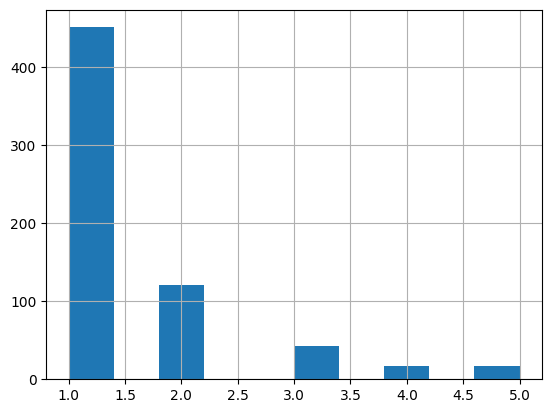

In [16]:
cleaned['Dalc'].hist()

Seing this distribution, the favorable class definetely appears to be in the lower ends. Thus, for seing how bias mitigation affects the outcomes, 1 and 2 will be set as priviledged, wheras the rest is  considered unpriviledged

In [17]:
# First define the necessary args

# train=stud_feat, 
# target=stud_targ,
# prot_attr=['sex'],
# priv_label='sex', 
# priv_cls=[1], 
# unpriv_cls=[0],
# priv_identifier= [lambda x: 1 if x == 'M' else 0],
# categorical_features=['school','address','famsize', 'Pstatus','Mjob', 'Fjob', 'reason', 'guardian'],

In [18]:
ds = StandardDataset(df=cleaned,
                    label_name='Dalc',
                    protected_attribute_names=['Dalc', 'age'],
                    favorable_classes=[1],
                    privileged_classes=[lambda x: 1 if x <= 2.0 else 0],
                    categorical_features=['school_GP', 'school_MS', 'sex_F', 'sex_M', 'address_R',
                                        'address_U', 'famsize_GT3', 'famsize_LE3', 'Pstatus_A', 'Pstatus_T',
                                        'Mjob_at_home', 'Mjob_health', 'Mjob_other', 'Mjob_services',
                                        'Mjob_teacher', 'Fjob_at_home', 'Fjob_health', 'Fjob_other',
                                        'Fjob_services', 'Fjob_teacher', 'reason_course', 'reason_home',
                                        'reason_other', 'reason_reputation', 'guardian_father',
                                        'guardian_mother', 'guardian_other']
                    )

Now we can make the first bias check

In [19]:
ds_train, ds_test = ds.split([0.8], shuffle=True)
priv_group = [{'Dalc': 1}]
unpriv_group = [{'Dalc': 0}]

In [20]:
# Check the mean difference between more and less Workday alchohol consumption
from aif360.metrics import BinaryLabelDatasetMetric
non_mit_metric = BinaryLabelDatasetMetric(ds_train, 
                                            unprivileged_groups=unpriv_group,
                                            privileged_groups=priv_group)

display(Markdown("#### Original training dataset"))
print("Difference in mean outcomes between unprivileged and privileged groups = %f" % non_mit_metric.mean_difference())

#### Original training dataset

Difference in mean outcomes between unprivileged and privileged groups = -1.000000


Apparently, the mean outcome completely favours less alcohol consumption. Let's check with a complete bias scan, what exactly leads to this outcome.

In [ ]:
from aif360.detectors.mdss_detector import bias_scan
import pprint

subset, score = bias_scan(data=cleaned, observations=targ)

In [22]:
pprint.pp(subset)
print(f'\n {score}')

{'guardian_father': [False, True],
 'Dalc': [1, 2, 3, 4, 5],
 'age': [15, 16, 17, 18, 19, 20, 21, 22],
 'traveltime': [1, 2, 3, 4],
 'Fjob_teacher': [False, True],
 'activities': [0, 1],
 'absences': [0,
              1,
              2,
              3,
              4,
              5,
              6,
              7,
              8,
              9,
              10,
              11,
              12,
              13,
              14,
              15,
              16,
              18,
              21,
              22,
              24,
              26,
              30,
              32],
 'school_MS': [False, True],
 'Fjob_health': [False, True],
 'sex_M': [False, True],
 'schoolsup': [0, 1],
 'address_R': [False, True],
 'internet': [0, 1],
 'Medu': [0, 1, 2, 3, 4],
 'Fjob_services': [False, True],
 'guardian_other': [False, True],
 'Walc': [1, 2, 3, 4, 5],
 'Fjob_other': [False, True],
 'address_U': [False, True],
 'romantic': [0, 1],
 'paid': [0, 1],
 'school_GP': [Fa

Supposedly the whole dataset is biased.

## Preprocessing

First, reweighing is tested

In [ ]:
importlib.reload(preprocessing)

# priv_group = [{'Dalc': 1}]
# unpriv_group = [{'Dalc': 0}]

# print(stud_ds.ds_feat_train.feature_names)
prep_inst = preprocessing.ExecPreprocess(dataset=ds, transform=True, predict=False)
rw = prep_inst.exec_reweighing(unpriviledged=unpriv_group, priveledged=priv_group).return_results()

To check the outcome, a a ml model is trained based on the results

In [24]:
importlib.reload(ml_methods)

rw_df = rw['reweighing_0']['transformed'].convert_to_dataframe()[0]

rw_feat_train, rw_feat_test, rw_targ_train, rw_targ_test = sklearn.model_selection.train_test_split(rw_df, targ, test_size=0.2)

rw_ml = ml_methods.MlModelProvider(train_feat=rw_feat_train, train_targ=rw_targ_train)

rw_res = rw_ml.random_forest(already_predict=True, test_feat=rw_feat_test).perceptron(already_predict=True, test_feat=rw_feat_test).return_results()

In [25]:
importlib.reload(calc_metrics)

# Check the model output
display(Markdown('#### Preprocessing ml Classification results'))
display(Markdown('##### Random Forest'))
rw_rf_metr = calc_metrics.calc_metr(predicted=rw_res['random_forest_0']['prediction'], actual=rw_targ_test)
display(Markdown('\n ##### Perceptron'))
rw_perc_metr = calc_metrics.calc_metr(predicted=rw_res['perceptron_1']['prediction'], actual=rw_targ_test)

# Now, let's check the bias metrics
rw_ds: BinaryLabelDataset = rw['reweighing_0']['transformed']
rw_des_test, rw_ds_train = rw_ds.split([0.2])


display(Markdown('#### Preprocessibg Classification metrics'))
rw_bias_metr = calc_metrics.calc_aif360_bin_label_metrics(
                                    dataset=rw['reweighing_0']['transformed'],
                                    unpriviledged=unpriv_group, 
                                    priviledged=priv_group)

from aif360.metrics import BinaryLabelDatasetMetric

rw_classf_metr = BinaryLabelDatasetMetric(dataset=rw['reweighing_0']['transformed'],
                                          unprivileged_groups=unpriv_group,
                                          privileged_groups=priv_group)

rw_aif360_perf = {
"Disparate impact": rw_classf_metr.disparate_impact(),
"Smoothed empricial differential fairness": rw_classf_metr.smoothed_empirical_differential_fairness(),
"Statistical parity": rw_classf_metr.statistical_parity_difference()
}

pprint.pp(rw_aif360_perf)

#### Preprocessing ml Classification results

##### Random Forest

Precision: 0.21020782726045883
Accuracy: 0.15384615384615385
F1-Score: 0.13249957746873492
Recall: 0.15384615384615385



 ##### Perceptron

Precision: 0.5665835446604678
Accuracy: 0.11538461538461539
F1-Score: 0.07288640237429002
Recall: 0.11538461538461539


#### Preprocessibg Classification metrics

Mean difference = -1.000000
Consistency = 0.891525
Disparate impact = 0.000000
{'Disparate impact': 0.0,
 'Smoothed empricial differential fairness': 5.528328938742544,
 'Statistical parity': -1.0}


Well, the ml metrics leave something to be desired, but at least the consistency is high.

## Inprocessing

For inprocessing testing, we use Adveserial debiasing. To do so, we need a split dataset and dataframe.

In [ ]:
importlib.reload(inprocessing)

# Split the dataframes
feat_train, feat_test, targ_train, targ_test = sklearn.model_selection.train_test_split(cleaned, targ, test_size=0.2)
# Split the preprocessed data
rw_train, rw_test = rw['reweighing_0']['transformed'].split([0.8], shuffle=True)
# Instantiate 
stud_inp_inst = inprocessing.ExecInprocess(dataset=rw_train)
stud_adv_deb = stud_inp_inst.exec_advesarial_debiasing(unpriviledged=unpriv_group,
                                                      priveledged=priv_group,
                                                      predict=True,
                                                      to_predict=rw_test).return_results()  

And the results ...

In [27]:
importlib.reload(calc_metrics)

stud_adv_deb_df = stud_adv_deb['adveserial_debiasing_0']['predicted'].convert_to_dataframe()[0]
print(stud_adv_deb_df.shape)

adv_deb_feat_train, adv_deb_feat_test, adv_deb_targ_train, adv_deb_targ_test = sklearn.model_selection.train_test_split(stud_adv_deb_df, targ_test, test_size=0.2)

adv_deb = ml_methods.MlModelProvider(train_feat=adv_deb_feat_train, train_targ=adv_deb_targ_train)

adv_deb_res = adv_deb.random_forest(already_predict=True, test_feat=adv_deb_feat_test).perceptron(already_predict=True, test_feat=adv_deb_feat_test).return_results()
# Check the model output
display(Markdown('#### Preprocessing ml Classification results'))
display(Markdown('##### Random Forest'))
adv_deb_rf_metr = calc_metrics.calc_metr(predicted=adv_deb_res['random_forest_0']['prediction'], actual=adv_deb_targ_test)
display(Markdown('\n ##### Perceptron'))
adv_deb_perc_metr = calc_metrics.calc_metr(predicted=adv_deb_res['perceptron_1']['prediction'], actual=adv_deb_targ_test)

# Now, let's check the bias metrics
adv_deb_train, adv_deb_test =  stud_adv_deb['adveserial_debiasing_0']['predicted'].split([0.2])


display(Markdown('#### Preprocessing Classification metrics'))
rw_bias_metr = calc_metrics.calc_aif360_bin_label_metrics(
                                    dataset=stud_adv_deb['adveserial_debiasing_0']['predicted'],
                                    unpriviledged=unpriv_group, 
                                    priviledged=priv_group)

(130, 75)


#### Preprocessing ml Classification results

##### Random Forest

Precision: 0.35943223443223443
Accuracy: 0.15384615384615385
F1-Score: 0.125
Recall: 0.15384615384615385



 ##### Perceptron

Precision: 0.6009615384615384
Accuracy: 0.038461538461538464
F1-Score: 0.02958579881656805
Recall: 0.038461538461538464


#### Preprocessing Classification metrics

Mean difference = 0.000000
Consistency = 1.000000
Disparate impact = 1.000000


In [ ]:
importlib.reload(calc_metrics)

display(Markdown('#### Inprocessing Classification metrics'))
rw_bias_metr = calc_metrics.calc_aif360_bias_metrics(
                                    mitigated=stud_adv_deb['adveserial_debiasing_0']['predicted'],
                                    original_ds=rw_test,
                                    unpriviledged=unpriv_group, 
                                    priviledged=priv_group
                                    )

Short summary: Performance of the ML modules goes down under, but the consistency is great

## And for the final: Postprocessing

In [ ]:
importlib.reload(postprocessing)

# no_mit_rf_pred_ds = inst_dataset.DatasetInstantiater(train=)

stud_inp_inst = postprocessing.ExecPostprocess(dataset=rw_test)
stud_ceq_odds = stud_inp_inst.exec_cal_equalized_odds(unpriviledged=unpriv_group,
                                                      priveledged=priv_group,
                                                      predicted=stud_adv_deb['adveserial_debiasing_0']['predicted']).return_results()   


print(stud_ceq_odds['eq_odds_0']['fitted'])

In [30]:
# And now for the classification metrics
importlib.reload(calc_metrics)

display(Markdown('#### Postprocessing Classification metrics'))
rw_bias_metr = calc_metrics.calc_aif360_bias_metrics(
                                    mitigated=stud_ceq_odds['eq_odds_0']['fitted'].predict(rw_train),
                                    original_ds=rw_train,
                                    unpriviledged=unpriv_group, 
                                    priviledged=priv_group
                                    )

#### Postprocessing Classification metrics

Classification accuracy = 1.000000
Balanced classification accuracy = 1.000000
Disparate impact = 0.000000
Equal opportunity difference = nan
Average odds difference = nan
Theil_index = 0.000000
